In [10]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %                   SCF-TB - PROXY APPLICATION                      %
# %                   A.M.N. Niklasson, M. Kulichenko. T1, LANL       %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Total Energy Function:                                            %
# % E = 2Tr[H0(D-D0)] + (1/2)*sum_i U_i q_i^2 +                       %
# %      + (1/2)sum_{i,j (i!=j)} q_i C_{ij} q_j - Efield*dipole       %
# % dipole = sum_i R_{i} q_i                                          %
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
import torch
import numpy as np
import sys
### path to PYSEQM ###
sys.path.insert(1, "/home/maxim/Projects/git2/PYSEQM_dev/")
from seqm.seqm_functions.read_xyz import read_xyz
import scipy.io as sio
import math
import pandas as pd
import importlib
import matplotlib.pyplot as plt

import dftorch
importlib.reload(dftorch)
import dftorch.CoulombMatrix
importlib.reload(dftorch.CoulombMatrix)
from dftorch.CoulombMatrix import CoulombMatrix_vectorized
from dftorch.SCF import SCF, SCF_adaptive_mixing

from dftorch.H0andS import H0_and_S_vectorized
from dftorch.Constants import Constants
from dftorch.nearestneighborlist import vectorized_nearestneighborlist
from dftorch.Energy import Energy
from dftorch.Tools import fractional_matrix_power_symm
from dftorch.Forces import Forces
from dftorch.BondIntegral import *
from dftorch.Tools import ordered_pairs_from_TYPE

import matplotlib.colors as mcolors


torch.set_default_dtype(torch.float64)
print(torch.cuda.memory_allocated() / 1e9, 'GB')

0.0 GB


In [16]:
%%time
# Initial data, load atoms and coordinates, etc in COORD.dat
device = 'cuda'
const = Constants().to(device)

Efield = 0*0.3*torch.tensor([-.3,0.4,0.0], device=device).T # In arbitrary direction  Works ony in 0-field!!!
Te = 3000.0                       # Some electronic temperature in Kelvin, Possible bug at high tempertures!!!

# species, coordinates = read_xyz(['COORD.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([8,4,4], device=device)

species, coordinates = read_xyz(['C840.xyz'], sort=False) #Input coordinate file
LBox = torch.tensor([38,38,38], device=device) #36

# species, coordinates = read_xyz(['solvated_1600.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([35,35,35], device=device)

# species, coordinates = read_xyz(['gs_solvated_4k.xyz'], sort=False) #Input coordinate file
# LBox = torch.tensor([100,100,100], device=device)

TYPE = torch.tensor(species[0], dtype=torch.int64, device=device)
RX = torch.tensor(coordinates[0,:,0], device=device).to(torch.get_default_dtype())
RY = torch.tensor(coordinates[0,:,1], device=device).to(torch.get_default_dtype())
RZ = torch.tensor(coordinates[0,:,2], device=device).to(torch.get_default_dtype())
Nocc = int(const.tore[TYPE].sum()/2)
Nats = len(RX)

# but first the neighborlist
#nrnnlist,nndist,nnRx,nnRy,nnRz,nnType,nnStruct,nrnnStruct  = vectorized_nearestneighborlist(RX,RY,RZ,LBox,4.0,Nats);
nrnnlist_no_self, nndist_no_self, nnRx_no_self, nnRy_no_self, nnRz_no_self, nnType_no_self, nnStruct_no_self, nrnnStruct_no_self  = \
        vectorized_nearestneighborlist(RX, RY, RZ, LBox, 5.5, Nats, upper_tri_only=False, remove_self_neigh=False);

# Get Hamiltonian, Overlap, atomic DM = D0 (vector only), etc, 
D0, H_INDEX_START, H_INDEX_END, Element_Type, Mnuc,Znuc, Hubbard_U, neighbor_I, neighbor_J, H0_SKF, dH0_SKF, S_SKF, dS_SKF = H0_and_S_vectorized(TYPE,RX,RY,RZ,LBox,Nats,
                                                                        nrnnlist_no_self,nnRx_no_self,nnRy_no_self,nnRz_no_self,nnType_no_self, const)
                                                                        
HDIM = max(H0_SKF.shape)           # Total number of basis functions


AssertionError: Torch not compiled with CUDA enabled

In [12]:
Rab_X = nnRx_no_self - RX.unsqueeze(-1)
Rab_Y = nnRy_no_self - RY.unsqueeze(-1)
Rab_Z = nnRz_no_self - RZ.unsqueeze(-1)

# Rab_X = Rab_X - LBox[0] * torch.round(Rab_X / LBox[0])
# Rab_Y = Rab_Y - LBox[1] * torch.round(Rab_Y / LBox[1])
# Rab_Z = Rab_Z - LBox[2] * torch.round(Rab_Z / LBox[2])

dR = torch.norm(torch.stack((Rab_X, Rab_Y, Rab_Z), dim=-1), dim=-1)

nn_mask = nnType_no_self!=-1 # mask to exclude zero padding from the neigh list
dR_mskd = dR[nn_mask]

pairs_tensor, pairs_list, label_list = ordered_pairs_from_TYPE(TYPE, const)
pairs_tensor, pairs_list, label_list

# Allocate padded tensors
n_pairs = len(label_list)
coeffs_tensor = torch.zeros((n_pairs, 500, 20, 4), device=RX.device)
#R_tensor = torch.zeros((n_pairs, 499), device=RX.device) # not necessarily if all R are the same. Makes sense to use zero padding if not.

pair_type_dict = {}

for i in range(len(label_list)):
    pair_type_dict[label_list[i]] = i
    R, channels = read_skf_table("sk_orig/mio-1-1/mio-1-1/{}.skf".format(label_list[i]))
    channels_matrix = channels_to_matrix(channels)
    coeffs = cubic_spline_coeffs(R, channels_matrix)
    #R_tensor[i] = R
    coeffs_tensor[i] = coeffs

coeffs_tensor = torch.cat((coeffs_tensor, torch.zeros(coeffs_tensor.shape[0], 1, coeffs_tensor.shape[2], coeffs_tensor.shape[3])), dim=1) # pad last channel with zeros

IJ_pair_type = torch.zeros((len(neighbor_I)), dtype=torch.int64, device=RX.device)
JI_pair_type = torch.zeros((len(neighbor_I)), dtype=torch.int64, device=RX.device)

for i in range(len(neighbor_I)):
    IJ_pair_type[i] = pair_type_dict[const.label[TYPE[neighbor_I[i]]] + '-' + const.label[TYPE[neighbor_J[i]]]]
    JI_pair_type[i] = pair_type_dict[const.label[TYPE[neighbor_J[i]]] + '-' + const.label[TYPE[neighbor_I[i]]]]

idx = torch.searchsorted(R, dR_mskd, right=True) - 1
idx = torch.clamp(idx, 0, len(R))
dx = (dR_mskd - R[idx])
coeffs_selected = coeffs_tensor[IJ_pair_type, idx, 9 + 1*10]
HSSS_all  = (coeffs_selected[:,0] + coeffs_selected[:,1]*dx + coeffs_selected[:,2]*dx**2 + coeffs_selected[:,3]*dx**3)/27.211396
HSSS_all

tensor([ 3.4923e-02,  2.3180e-02,  7.7879e-03,  ...,  2.6930e-02,
         4.2593e-05, -4.4838e-05])

In [13]:
#Z = matrix_inverse_sqrt(S)  # Factorization Z of the inverse overlap matrix S. Z is the inverse square root of S
#Z0 = Z  # Z0 is the same as Z
#S0 = S  # Store S as S0

# Parameters for the Coulomb summations
Rcut = 15.42
Coulomb_acc = 1e-9
TIMERATIO = 10

# Get full Coulomb matrix. In principle we do not need an explicit representation of the Coulomb matrix C!
nrnnlist, nndist, nnRx, nnRy, nnRz, nnType, nnStruct, nrnnStruct  = vectorized_nearestneighborlist(RX,RY,RZ,LBox,Rcut,Nats,
                                                                                                   upper_tri_only=False, remove_self_neigh=False)
C, dCC = CoulombMatrix_vectorized(RX,RY,RZ,LBox,Hubbard_U,Element_Type,Nats,HDIM,Coulomb_acc,TIMERATIO,nnRx,nnRy,nnRz,nrnnlist,nnType,
                                  H_INDEX_START,H_INDEX_END)

CoulombMatrix_vectorized
  Do Coulomb Real
  Coulomb_Real t 0.0 s

  Doing Coulomb k
   LMAX: 11
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
   11
  Coulomb_k t 4.5 s



In [15]:
H, Hcoul, Hdipole, D, q, f = SCF_adaptive_mixing(
    H0_SKF.to(torch.float64), S_SKF.to(torch.float64), Efield.to(torch.float64), C.to(torch.float64), 
    TYPE, RX.to(torch.float64), RY.to(torch.float64), RZ.to(torch.float64),
    H_INDEX_START, H_INDEX_END,
    Nocc, Hubbard_U, Znuc, Nats, Te, const,
    #mixing="anderson", anderson_m=6, anderson_lam=1e-10, anderson_damp=1.0,
    mixing="adaptive", alpha0=0.1, alpha_min=0.0051, alpha_max=0.6,
    acc=1e-6, MAX_ITER=100)

Etot,Eband0,Ecoul,Edipole,S_ent = Energy(H0_SKF.to(torch.float64), Hubbard_U, Efield, D0, C.to(torch.float64), D, q,
                                         RX, RY, RZ, f, Te) # Energy calculation - 2*Te*S_ent
Etot,Eband0,Ecoul,Edipole,S_ent

### Do SCF (adaptive mixing) ###
  Initial DM_Fermi

Starting cycle
Iter 1
  Hcoul 0.040 s
  DM_Fermi 1.185 s
  Z@Dorth@Z.T 0.239 s
  mix: method=adaptive, Res=9.045e-01, alpha=0.100
  update q 0.015 s
  iter wall 1.480 s

Iter 2
  Hcoul 0.048 s
  DM_Fermi 1.253 s
  Z@Dorth@Z.T 0.238 s
  mix: method=adaptive, Res=5.200e-01, alpha=0.115
  update q 0.016 s
  iter wall 1.556 s

Iter 3
  Hcoul 0.051 s
  DM_Fermi 1.291 s
  Z@Dorth@Z.T 0.238 s
  mix: method=adaptive, Res=2.922e-01, alpha=0.132
  update q 0.016 s
  iter wall 1.597 s

Iter 4
  Hcoul 0.051 s
  DM_Fermi 1.283 s
  Z@Dorth@Z.T 0.238 s
  mix: method=adaptive, Res=1.609e-01, alpha=0.152
  update q 0.016 s
  iter wall 1.588 s

Iter 5
  Hcoul 0.050 s
  DM_Fermi 1.279 s
  Z@Dorth@Z.T 0.240 s
  mix: method=adaptive, Res=8.823e-02, alpha=0.175
  update q 0.015 s
  iter wall 1.584 s

Iter 6
  Hcoul 0.051 s
  DM_Fermi 1.272 s
  Z@Dorth@Z.T 0.238 s
  mix: method=adaptive, Res=4.824e-02, alpha=0.201
  update q 0.015 s
  iter wall 1.576 s

It

(-41335.56628164839,
 -41329.44780634126,
 0.07390747239986113,
 -0.0,
 0.0010320637965872766)

In [9]:
torch.max(abs(S_SKF - S_SKF.T))

tensor(2.2204e-16)

# Reference energies from external code for H4 x 4
## 3x3x3
## Gamma: 
-125.227932504 eV, 0.055004849825 eV
## non-periodic:
Eband0_ref = - eV, Coulomb =  eV


# Reference energies from external code for CH4x4
## 3x3x3
Eband0_ref = -325.9299084949 eV, Coulomb = 0.23888315743 eV
## Gamma:
Eband0_ref = -324.0143321298 eV, Coulomb = 0.26156413061 eV
## non-periodic:
Eband0_ref = -332.4583633955 eV, Coulomb = 0.22408478231 eV


In [ ]:
(-41335.56767158603,
 -41329.4486382197,
 0.0731371883250066,
 -0.0,
 0.001032028425776079)

In [ ]:
-325.8220340738 || 0.25209782912
(-325.5624819106642,
 -325.8145134724709,
 0.25212579195495266,
 -0.0,
 1.5705024710067222e-08)

In [ ]:
-41329.4459921498, 0.074025345612

(-41335.5665272166,
 -41329.44826177853,
 0.07401676338423627,
 -0.0,
 0.0010320470335759943)

In [ ]:
-41329.4618376196, 0.07401772642 || -41329.4459921498, 0.074025345612

(-41335.5665272166,
 -41329.44826177853,
 0.07401676338423627,
 -0.0,
 0.0010320470335759943)

In [ ]:
# 840 float64
# (-39404.09420944266,
#  -39397.984054503504,
#  0.07693157653150812,
#  -0.0,
#  0.0010311810859465263)

In [ ]:
# solvated_1600 float64
# (-61548.157759318965,
#  -61777.7014752535,
#  230.9621451599262,
#  -0.0,
#  0.00023640487089745803)

In [ ]:
# 840 float32
# (-39404.0940854571,
#  -39397.98393173635,
#  0.07693171958186243,
#  -0.0,
#  0.0010311809067218881)

In [ ]:
# solvated_1600 float32
# (-61546.65828309646,
#  -61777.15776222434,
#  231.91851268616983,
#  -0.0,
#  0.0002365055930485986)


In [ ]:
%%time
Ftot, Fcoul, Fband0, Fdipole, FPulay, FScoul, FSdipole = Forces(H.to(torch.float64), H0.to(torch.float64),
                                                                S.to(torch.float64), C.to(torch.float64), D.to(torch.float64), D0.to(torch.float64),
                                                                dH0.to(torch.float64), dS.to(torch.float64),
                   dCC.to(torch.float64), Efield, Hubbard_U, q, RX.to(torch.float64), RY.to(torch.float64), RZ.to(torch.float64),
                   Nats, H_INDEX_START, H_INDEX_END, const, TYPE)
#torch.save(Ftot, 'Ftot_840.pt')

Doing Fcoul
Doing Fband0
Doing Pulay
  Doing fractional_matrix_power_symm
Doing Fdipole
Doing FScoul
Doing FSdipole
CPU times: user 248 ms, sys: 13.6 ms, total: 261 ms
Wall time: 14 ms


In [ ]:
torch.max(abs(torch.load('Ftot_840.pt') - Ftot)), 

(tensor(0.),)

In [ ]:
torch.max(torch.load('Ftot_1600.pt') - Ftot)

tensor(0.)

In [ ]:
pairs_tensor, pairs_list, label_list = ordered_pairs_from_TYPE(TYPE, const)
pairs_tensor, pairs_list, label_list

(tensor([[1, 1],
         [1, 6],
         [6, 1],
         [6, 6]]),
 [(1, 1), (1, 6), (6, 1), (6, 6)],
 ['H-H', 'H-C', 'C-H', 'C-C'])

In [ ]:
const.label[TYPE[neighbor_I]], const.label[TYPE[neighbor_J]]

(array(['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
        'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
        'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
        'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',
        'H', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H'

In [ ]:
TYPE[neighbor_I]

tensor([8, 8, 8,  ..., 8, 8, 1])

In [ ]:
set(torch.vstack((TYPE[neighbor_I], TYPE[neighbor_J])).T.tolist())

TypeError: unhashable type: 'list'

In [ ]:
torch.vstack((TYPE[neighbor_I], TYPE[neighbor_J])).T.numpy()

array([[8, 7],
       [8, 7],
       [1, 1]])

In [ ]:
pair_mask_HH = (const.n_orb[TYPE[neighbor_I]] == 1)*(const.n_orb[TYPE[neighbor_J]] == 1)
pair_mask_HX = (const.n_orb[TYPE[neighbor_I]] == 1)*(const.n_orb[TYPE[neighbor_J]] == 4)
pair_mask_XH = (const.n_orb[TYPE[neighbor_I]] == 4)*(const.n_orb[TYPE[neighbor_J]] == 1)    
pair_mask_XX = (const.n_orb[TYPE[neighbor_I]] == 4)*(const.n_orb[TYPE[neighbor_J]] == 4)


# H-H
hh = H_INDEX_START[neighbor_I[pair_mask_HH]]*HDIM + H_INDEX_START[neighbor_J[pair_mask_HH]]

# H-X
idx_row = H_INDEX_START[neighbor_I[pair_mask_HX]]
idx_col = H_INDEX_START[neighbor_J[pair_mask_HX]]

hx = idx_row*HDIM + idx_col

# X-H
idx_row = H_INDEX_START[neighbor_I[pair_mask_XH]]
idx_col = H_INDEX_START[neighbor_J[pair_mask_XH]]

xh = idx_row*HDIM + idx_col

# X-X
idx_row = H_INDEX_START[neighbor_I[pair_mask_XX]]
idx_col = H_INDEX_START[neighbor_J[pair_mask_XX]]

xx = idx_row*HDIM + idx_col

all_idx = H_INDEX_START[neighbor_I]*HDIM + H_INDEX_START[neighbor_J]

In [ ]:
b

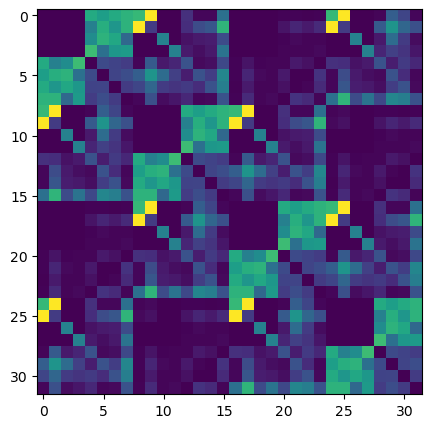

In [ ]:
plt.figure(figsize=(5,5))
data = abs(H0_SKF - H0) + 0.5
im = plt.imshow(data, cmap="viridis", norm=mcolors.LogNorm(vmin=data.min(), vmax=data.max()),
                   interpolation=None)


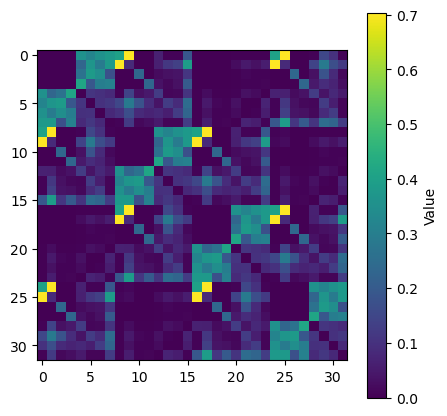

In [ ]:
plt.figure(figsize=(5,5))
data = abs(H0_SKF - H0)
im = plt.imshow(data, cmap="viridis", 
                #norm=mcolors.LogNorm(vmin=data.min(), vmax=data.max()),
                   interpolation=None)
plt.colorbar(label="Value")


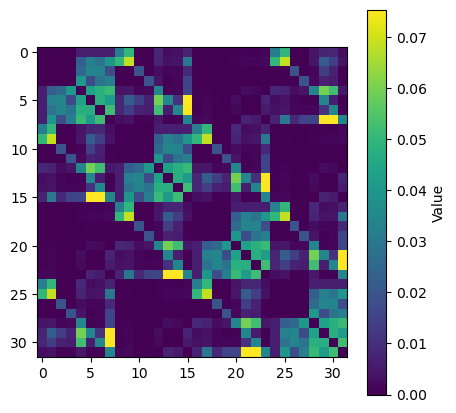

In [ ]:
plt.figure(figsize=(5,5))
data = abs(S_SKF - S)
im = plt.imshow(data, cmap="viridis", 
                #norm=mcolors.LogNorm(vmin=data.min(), vmax=data.max()),
                   interpolation=None)
plt.colorbar(label="Value")


In [ ]:
TYPE

tensor([6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1, 6, 1, 1, 1, 1])

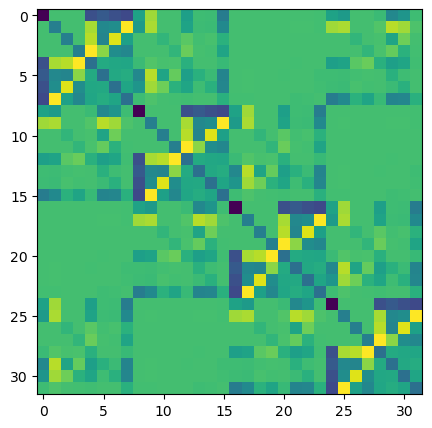

In [ ]:
plt.figure(figsize=(5,5))
data = H0_SKF
im = plt.imshow(data, cmap="viridis", 
                #norm=mcolors.LogNorm(vmin=data.min(), vmax=data.max()),
                   interpolation=None)


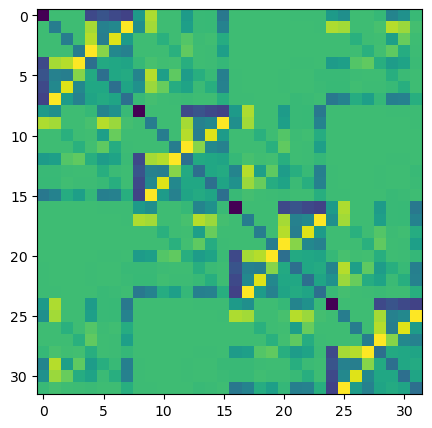

In [ ]:
plt.figure(figsize=(5,5))
data = H0
im = plt.imshow(data, cmap="viridis", 
                #norm=mcolors.LogNorm(vmin=data.min(), vmax=data.max()),
                   interpolation=None)


# Reference energies from external code
## 3x3x3
Eband0_ref = -325.9299084949 eV, Coulomb = 0.23888315743 eV
## Gamma:
Eband0_ref = -324.0143321298 eV, Coulomb = 0.26156413061 eV
## non-periodic:
Eband0_ref = -332.4583633955 eV, Coulomb = 0.22408478231 eV
